In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from tqdm.notebook import tqdm
import pickle
from functions import get_var_hist, create_R_v1, get_dyn_v2, get_theo_var_l_two_time
from functions import SimulationManager, SolverManager
from setup import setup_matplotlib, one_col, two_col, std_height
from scipy.linalg import expm

setup_matplotlib()

np.random.seed(42)

In [3]:
# def get_prop_abs_v2_g(x_s, force, D,dt,dx, N_border=None, side = 'lr'):
#     # x(t-tau), x(t), res
#     N_x = len(x_s)
#     half_x_s = np.arange(x_s[0],x_s[-1]+dx/4,dx/2)
#     mx_s = np.arange(x_s[0]-dx/2,x_s[-1]+dx/2+dx/4,dx)
    
    
    
#     R_abs = np.zeros(( len(half_x_s),N_x, N_x))
    
#     F = force(half_x_s[:,None], mx_s[None,:])
    
#     lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
#     ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i

#     R_abs[:,np.arange(0,N_x),np.arange(0,N_x)] = -(lp[:,1:]+ln[:,:-1]) # -(r_i->i+1 + r_i->i-1) ????
#     R_abs[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,1:-1]
#     R_abs[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,1:-1]
    
#     prop_abs = expm(R_abs*dt, )
#     if np.any(np.isnan(prop_abs)):
#         print('CAREFUL: nan in prop, maybe because of to high values in potential')
#     return prop_abs

In [4]:
version = 2

k = 1
k2 = 1
s = 1
D = s**2/2
max_t = 6
ntau = 3
eq_perc = 0.75
N_x = 25
hist_sigma = 4
avg_part = 4
force = "general"


f = 15
N_p = 2_000
N_loop = 20
ntau_sim = ntau*f


ltaus = np.concatenate(([0.05], np.arange(0.2,2.2,0.1) ))
sim_vars = np.empty((len(ltaus),2))
sim_eq_time = np.empty((len(ltaus),2))

sim_hist_vars = np.empty((len(ltaus),2))
sim_hist_eq_time = np.empty((len(ltaus),2))

num_vars = np.empty((len(ltaus),2))
num_eq_time = np.empty((len(ltaus),2))

sbs = np.empty(len(ltaus))

In [5]:
my_sim_manager = SimulationManager()

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau_sim if ltau > 0 else ltaus[1]/ntau_sim
    N_t = int(max_t/ldt)+1

    if ltau > 0:
        res = my_sim_manager.run(
            N_p=N_p,
            N_loop=N_loop,
            N_t=N_t,
            N_x=N_x,
            ntau=ntau_sim,
            s=s,
            dt=ldt,
            x_0=0,
            force=force,
            hist_sigma=hist_sigma,
        )
    else:
        res = my_sim_manager.run(
            N_p=N_p,
            N_loop=N_loop,
            N_t=N_t,
            N_x=N_x,
            ntau=0,
            s=s,
            dt=ldt,
            x_0=0,
            force=force,
            hist_sigma=hist_sigma,
        )
    
    sim_ts = np.arange(0,(N_t+ntau_sim))*ldt-ltau

    sim_var = res['sim_var']
    sim_hist_var = res['sim_hist_var']
    x_s =  res['x_s']
    sbs[i] = -x_s[0]
    

    mean_sim_vars = np.mean(sim_var[:,-N_t//avg_part:], axis = 1)
    sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))
    
    mean_s_eq = sim_ts[np.argmin((eq_perc*mean_sim_vars[:,None]-sim_var)**2, axis = 1)]
    sim_eq_time[i] = (np.mean(mean_s_eq), np.std(mean_s_eq)/np.sqrt(N_loop))
    
    mean_sim_hist_var = np.mean(sim_hist_var[:,-N_t//avg_part:], axis = 1)
    sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))
    
    mean_sh_eq = sim_ts[np.argmin((eq_perc*mean_sim_hist_var[:,None]-sim_hist_var)**2, axis = 1)]
    sim_hist_eq_time[i] = (np.mean(mean_sh_eq), np.std(mean_sh_eq)/np.sqrt(N_loop))

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [01:36<00:00,  4.57s/it]


In [6]:
my_num_manager = SolverManager()

for i, ltau in enumerate(tqdm(ltaus)):
    ldt = ltau / ntau if ltau > 0 else ltaus[1]/ntau
    N_t = int(max_t / ldt) + 1

    ts = np.arange(0, N_t) * ldt

    sb = sbs[i]

    if ltau > 0:
        res = my_num_manager.run(
            N_t=N_t, N_x=N_x, sb=sb, ntau=ntau, s=s, dt=ldt, x_0=0, force=force, version = version
        )
    else:
        res = my_num_manager.run(
            N_t=N_t, N_x=N_x, sb=sb, ntau=0, s=s, dt=ldt, x_0=0, force=force, version = version
        )

    num_var = res["num_var"]

    mean_num_var = np.mean(num_var[-N_t//avg_part :])
    num_vars[i] = (
        mean_num_var,
        np.max(num_var[-N_t//avg_part:]) - np.min(num_var[-N_t//avg_part:]),
    )
    num_eq_time[i] = ts[np.argmin((eq_perc * mean_num_var - num_var) ** 2)]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


In [7]:
# for i,ltau in enumerate(tqdm(ltaus)): 
#     ldt_sim = ltau/ntau_sim if ltau > 0 else ltaus[1]/ntau_sim
#     N_t_sim = int(max_t/ldt_sim)+1
#     sim_ts = np.arange(0,(N_t_sim+ntau_sim))*ldt_sim-ltau
#     pos = simulate_traj_g(N_p=N_p, N_loop=N_loop, N_t=N_t_sim, ntau=ntau_sim, s=s, dt=ldt_sim ,border=0, force=force)
#     sim_var = np.var(pos, axis = 1)
    
#     sb = hist_sigma*np.sqrt(np.max(sim_var))
#     dx = 2*sb/(N_x-1)
    
#     x_s = np.arange(-sb,sb+1e-6,dx)
#     bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
#     i_zero = np.argmin(x_s**2)

    
#     sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
#     sim_hist_var =  np.apply_along_axis(get_var_hist,-1, sim_hists, x_s=x_s)
    
#     if ltau > 0:
#         ldt = ltau/ntau if ltau > 0 else ltaus[1]/ntau
#         N_t = int(max_t/ldt)+1
#         ts = np.arange(0,N_t)*ldt
#         # v1
#         # prop = get_prop_abs(x_s, force,D,ldt,dx)
#         # R, _, end_states = create_R(N_x, ntau, prop)

#         # v2
#         prop = get_prop_abs_v2_g(x_s, force,D,ldt,dx)
#         R, _, end_states = create_R_v1(N_x, ntau, prop)

#         _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)
#     else:
#         print('tau = 0, Not integrated jet !!!!')
#         continue
    
#     num_var = get_var_hist(hists, x_s)
    
#     mean_sim_vars = np.mean(sim_var[:,-ntau_sim*2:], axis = 1)
#     sim_vars[i] = (np.mean(mean_sim_vars), np.std(mean_sim_vars)/np.sqrt(N_loop))
    
#     mean_s_eq = sim_ts[np.argmin((eq_perc*mean_sim_vars[:,None]-sim_var)**2, axis = 1)]
#     sim_eq_time[i] = (np.mean(mean_s_eq), np.std(mean_s_eq)/np.sqrt(N_loop))
    
    
#     mean_sim_hist_var = np.mean(sim_hist_var[:,-ntau_sim*2:], axis = 1)
#     sim_hist_vars[i] = (np.mean(mean_sim_hist_var), np.std(mean_sim_hist_var)/np.sqrt(N_loop))
    
#     mean_sh_eq = sim_ts[np.argmin((eq_perc*mean_sim_hist_var[:,None]-sim_hist_var)**2, axis = 1)]
#     sim_hist_eq_time[i] = (np.mean(mean_sh_eq), np.std(mean_sh_eq)/np.sqrt(N_loop))
                  
#     mean_num_var = np.mean(num_var[-ntau*2:])
#     num_vars[i] =  (mean_num_var, np.max(num_var[-ntau*2:])-np.min(num_var[-ntau*2:]))
#     num_eq_time[i] =  ts[np.argmin((eq_perc*mean_num_var-num_var)**2)]

In [8]:
exact_sol = [get_theo_var_l_two_time(np.linspace(0,max_t, 1000), tau, D)[-1] for tau in ltaus]

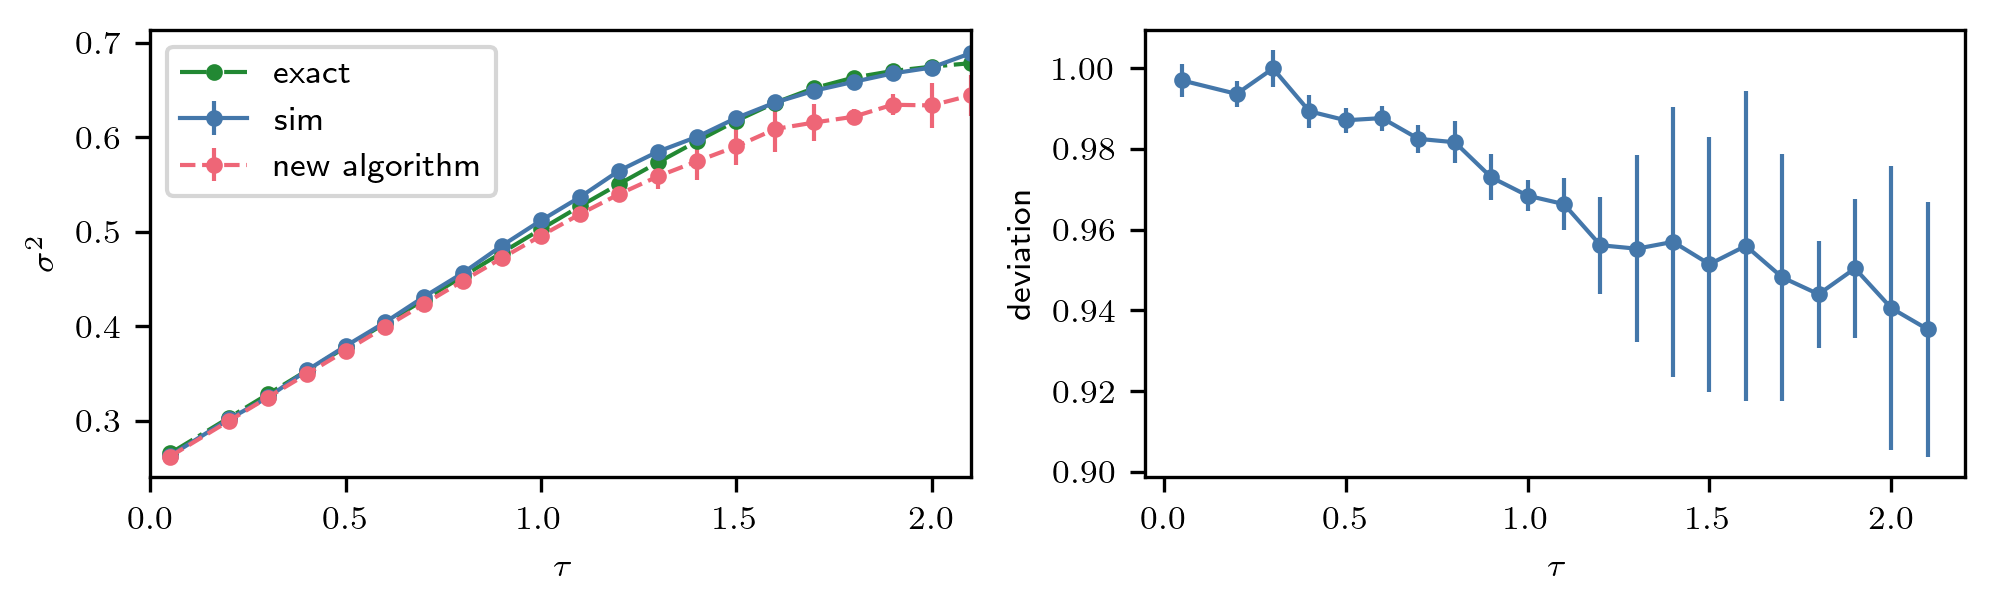

In [9]:
plt.figure(figsize=(two_col,std_height))
ax = plt.subplot(121)
plt.errorbar(ltaus,*sim_vars.T, ls='-' ,marker ='.', label='sim')

#plt.errorbar(ltaus,num_vars[:,0],num_vars[:,1],marker='.', ls='--', label='new algorithm')
plt.errorbar(ltaus,*num_vars.T,marker='.', ls='--', label='new algorithm')



#plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')
plt.plot(ltaus,exact_sol ,'.-.',label='exact')

# plt.errorbar(ltaus,sim_hist_vars[:,0],sim_hist_vars[:,1],marker='.', label='hist-sim')
#plt.ylim(3e-1,10)
plt.ylim(*plt.ylim())
plt.xlim(0,2.1)
#plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
#y = 4e-1
# plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
# plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
# plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')

#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')

#auflösungslimit
#plt.hlines((x_s[-1]/3)**2, *plt.xlim())

ax = plt.subplot(122)
plt.errorbar(ltaus, num_vars[:,0]/sim_vars[:,0], 
             yerr = np.sqrt( ( num_vars[:,1]/sim_vars[:,0])**2 + (num_vars[:,0]/sim_vars[:,0]**2*sim_vars[:,1])**2),
                            marker = '.')
#plt.plot(ltaus, num_vars[:,0]/sim_vars[:,0], '.-')
plt.xlabel(r'$\tau$')
plt.ylabel(r'deviation')


plt.tight_layout()
plt.savefig('graphics/x2variance_v2_g.pdf')

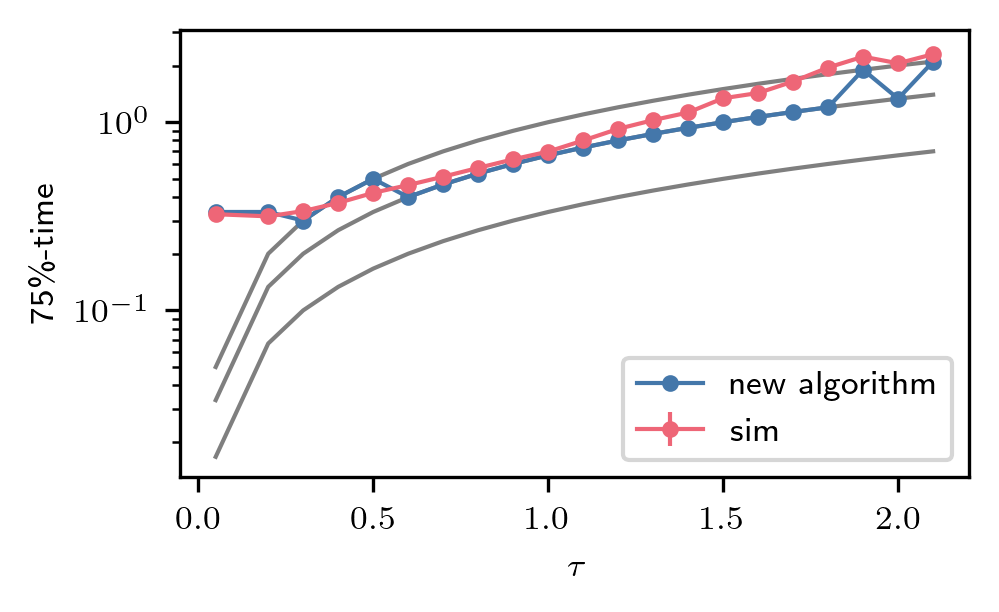

In [10]:
plt.plot(ltaus, ltaus, color = 'black', alpha = 0.5)
plt.plot(ltaus, ltaus/3, color = 'black', alpha = 0.5)
plt.plot(ltaus, ltaus/3*2, color = 'black', alpha = 0.5)

plt.plot(ltaus, num_eq_time[:,0], marker ='.', label = 'new algorithm')
#plt.errorbar(ltaus, *sim_hist_eq_time.T, marker ='.', label = 'hist-sim')
plt.errorbar(ltaus, *sim_eq_time.T, marker ='.', label = 'sim')



plt.legend()
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'75\%-time')
plt.tight_layout()